# Neural Network Training & Gaussianization
Pre-Activations Show True CLT Behavior

**Blog Post Thesis**: 
> "Each layer ≈ summing many weighted inputs → Deep networks = repeated CLT application"

1. **ReLU DESTROYS Gaussianity** 
   - ReLU(x) = max(0, x) creates half-Gaussian (skewed!)
   - **Solution**: Analyze **PRE-activations** (before ReLU)

2. **Need WIDE layers for strong CLT**
   - 512 neurons → sum of 512 weighted inputs → Strong CLT!

3. **Two stories of convergence**:
   - **Spatial**: Through network depth (Layer 1 → 2 → 3 → 4)
   - **Temporal**: Through training time (Epoch 0 → 10 → 20 → 30)

---

In [91]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm  # Import norm directly to avoid collision!
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

## Create Synthetic MNIST Dataset

In [92]:
def create_synthetic_mnist(n_train=5000, n_test=1000):
    X_train, y_train = [], []
    
    for c in range(10):
        n = n_train // 10
        mean_shift = (c - 4.5) * 0.1
        X_class = np.random.randn(n, 784) * 0.5 + mean_shift
        y_class = np.ones(n) * c
        X_train.append(X_class)
        y_train.append(y_class)
    
    X_train = np.vstack(X_train)
    y_train = np.concatenate(y_train).astype(int)
    idx = np.random.permutation(len(X_train))
    X_train, y_train = X_train[idx], y_train[idx]
    
    X_test, y_test = [], []
    for c in range(10):
        n = n_test // 10
        mean_shift = (c - 4.5) * 0.1
        X_class = np.random.randn(n, 784) * 0.5 + mean_shift
        y_class = np.ones(n) * c
        X_test.append(X_class)
        y_test.append(y_class)
    
    X_test = np.vstack(X_test)
    y_test = np.concatenate(y_test).astype(int)
    
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = create_synthetic_mnist()
print(f"Dataset: Train={X_train.shape}, Test={X_test.shape}, Classes=10")

Dataset: Train=(5000, 784), Test=(1000, 784), Classes=10


## Build Neural Network

Each pre-activation is a sum of 512 weighted inputs

**Stability features**:
- Gradient clipping (±5.0)
- Lower learning rate (0.001)
- Stable softmax
- Safe cross-entropy

In [93]:
class MNISTmodel:
    def __init__(self, hidden_dims=[512, 512, 512, 256]):
        self.layer_sizes = [784] + hidden_dims + [10]
        self.num_layers = len(self.layer_sizes) - 1
        
        # Xavier initialization
        self.weights = []
        self.biases = []
        for i in range(self.num_layers):
            n_in, n_out = self.layer_sizes[i], self.layer_sizes[i+1]
            W = np.random.randn(n_in, n_out) / np.sqrt(n_in)
            b = np.zeros(n_out)
            self.weights.append(W)
            self.biases.append(b)
    
    def relu(self, z):
        return np.maximum(0, z)
    
    def softmax(self, z):
        # Stable softmax
        z_stable = z - np.max(z, axis=1, keepdims=True)
        exp_z = np.exp(np.clip(z_stable, -50, 50))
        return exp_z / (np.sum(exp_z, axis=1, keepdims=True) + 1e-10)
    
    def forward(self, X, track=True):
        if not track:
            a = X
            for i in range(self.num_layers - 1):
                z = a @ self.weights[i] + self.biases[i]
                a = self.relu(z)
            z = a @ self.weights[-1] + self.biases[-1]
            return self.softmax(z)
        
        pre_acts, post_acts = [], [X]
        a = X
        
        for i in range(self.num_layers):
            z = a @ self.weights[i] + self.biases[i]
            pre_acts.append(z)
            
            if i < self.num_layers - 1:
                a = self.relu(z)
            else:
                a = self.softmax(z)
            post_acts.append(a)
        
        return {'pre': pre_acts, 'post': post_acts, 'output': a}
    
    def train_step(self, X, y, lr=0.001):
        n = X.shape[0]
        result = self.forward(X, track=True)
        output = result['output']
        
        y_onehot = np.zeros((n, 10))
        y_onehot[np.arange(n), y] = 1
        
        # Backprop
        dz = output - y_onehot
        
        for i in range(self.num_layers - 1, -1, -1):
            dW = result['post'][i].T @ dz / n
            db = np.sum(dz, axis=0) / n
            
            # Gradient clipping
            dW = np.clip(dW, -5.0, 5.0)
            db = np.clip(db, -5.0, 5.0)
            
            self.weights[i] -= lr * dW
            self.biases[i] -= lr * db
            
            if i > 0:
                dz = (dz @ self.weights[i].T) * (result['pre'][i-1] > 0)
                dz = np.clip(dz, -10.0, 10.0)
        
        loss = -np.sum(y_onehot * np.log(output + 1e-10)) / n
        return loss

    def compute_gradients(self, X, y):
        """
        Compute gradients without updating weights.
        Returns dictionary of gradients for each layer.
        """
        n = X.shape[0]
        
        # Convert y to one-hot if needed
        if y.ndim == 1:
            y_onehot = np.zeros((n, 10))
            y_onehot[np.arange(n), y] = 1
            y = y_onehot
        
        # Forward pass
        result = self.forward(X, track=True)
        probs = result['output']
        
        # Backward pass
        dz = probs - y
        
        gradients = {}
        
        # Backprop through layers
        for i in range(len(self.weights) - 1, -1, -1):
            # Compute weight gradients
            if i == 0:
                dW = np.dot(X.T, dz) / n
            else:
                a_prev = result['post'][i]
                dW = np.dot(a_prev.T, dz) / n
            
            db = np.sum(dz, axis=0) / n
            
            # Clip for stability
            dW = np.clip(dW, -5.0, 5.0)
            db = np.clip(db, -5.0, 5.0)
            
            # Store gradients (only for hidden layers)
            if i > 0 and i < len(self.weights) - 1:
                gradients[f'layer_{i}'] = {'dW': dW.copy(), 'db': db.copy()}
            
            # Backprop to previous layer
            if i > 0:
                dz = np.dot(dz, self.weights[i].T)
                # ReLU derivative
                dz = dz * (result['pre'][i-1] > 0)
                dz = np.clip(dz, -10.0, 10.0)
        
        return gradients

    def accuracy(self, X, y):
        probs = self.forward(X, track=False)
        preds = np.argmax(probs, axis=1)
        return np.mean(preds == y)

model = MNISTmodel(hidden_dims=[512, 512, 512, 256])
print(f"Network: {model.layer_sizes}")
print(f"  Params: {sum(w.size for w in model.weights):,}")
print(f"  Initial acc: {model.accuracy(X_test, y_test)*100:.1f}% (random ≈ 10%)")

Network: [784, 512, 512, 512, 256, 10]
  Params: 1,059,328
  Initial acc: 11.3% (random ≈ 10%)


In [94]:
def compute_cumulants(data):
    data = data.flatten()
    m = {}
    for r in range(1, 5):
        m[r] = np.mean(data**r)
    k = {}
    k[1] = m[1]
    k[2] = m[2] - m[1]**2
    k[3] = m[3] - 3*m[2]*m[1] + 2*m[1]**3
    k[4] = m[4] - 4*m[3]*m[1] - 3*m[2]**2 + 12*m[2]*m[1]**2 - 6*m[1]**4
    return k

def analyze_layer(data):
    data = data.flatten()
    data = data[np.isfinite(data)]  # Remove NaN/Inf
    
    if len(data) == 0:
        return {'mean': 0, 'std': 1, 'var': 1, 'k3': 0, 'k4': 0,
                'std_k3': 0, 'std_k4': 0, 'score': 0, 'data': np.array([0])}
    
    k = compute_cumulants(data)
    sigma = np.sqrt(k[2]) if k[2] > 0 else 1
    
    return {
        'mean': np.mean(data),
        'std': np.std(data),
        'var': np.var(data),
        'k3': k[3],
        'k4': k[4],
        'std_k3': abs(k[3] / sigma**3) if sigma > 0 else 0,
        'std_k4': abs(k[4] / sigma**4) if sigma > 0 else 0,
        # 'score': abs(k[3] / sigma**3) + (1/len(data)) * abs(k[4] / sigma**4),
        'score': ( (k[3] / sigma**3)**2 +  ( abs(k[4] / sigma**4) )**2 )**0.5,
        'data': data if len(data) < 100000 else np.random.choice(data, 100000, False)
    }

In [96]:
def train_and_snapshot(model, X_train, y_train, X_test, y_test,
                        epochs=30, batch_size=64, lr=0.001,
                        snapshot_epochs=[0, 10, 20, 30]):
    
    history = {'loss': [], 'acc': [], 'snapshots': {}}
    sample_batch = X_train[:2000]
    
    print("Training...\n")
    
    # NEW: Track gradients as well as activations
    gradient_history = {}
    
    for epoch in range(epochs + 1):
        if epoch in snapshot_epochs:
            result = model.forward(sample_batch, track=True)
            snapshot = {'epoch': epoch}
            
            # Capture activation distributions (pre-activations)
            for i in range(len(result['pre']) - 1):
                snapshot[f'layer_{i+1}'] = analyze_layer(result['pre'][i])
            
            history['snapshots'][epoch] = snapshot
            
            # NEW: Capture gradient distributions
            # Take a small batch and compute gradients
            sample_indices = np.random.choice(len(X_train), 64, replace=False)
            X_grad_batch = X_train[sample_indices]
            y_grad_batch = y_train[sample_indices]
            
            # Compute gradients without updating weights
            grads = model.compute_gradients(X_grad_batch, y_grad_batch)
            
            # Analyze gradient distributions
            grad_snapshot = {}
            for layer_name, grad_dict in grads.items():
                if 'dW' in grad_dict:
                    grad_snapshot[layer_name] = analyze_layer(grad_dict['dW'].flatten())
            
            gradient_history[epoch] = grad_snapshot
            
            # Compute and store accuracy
            acc = model.accuracy(X_test, y_test)
            history['acc'].append(acc)  # Store accuracy
            
            print(f"Epoch {epoch:3d}: Acc={acc*100:5.2f}%  (Snapshot saved)")
        
        if epoch == 0:
            continue
        
        # Training
        indices = np.random.permutation(len(X_train))
        X_shuffled = X_train[indices]
        y_shuffled = y_train[indices]
        
        for i in range(0, len(X_train), batch_size):
            X_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]
            
            loss = model.train_step(X_batch, y_batch, lr=lr)
            history['loss'].append(loss)
    
    # Store gradient history in the main history dict
    history['gradients'] = gradient_history
    
    return history

## Compare Three Initialization Schemes

3 networks with different initializations and watch them converge:

1. **Uniform** U(-0.1, 0.1) - Bounded, non-Gaussian
2. **Standard Normal** N(0, 1) - Wrong scale
3. **Xavier** N(0, 1/√n) - Proper scale ✓

**Hypothesis**: All should converge to Gaussian through training!

In [97]:
# Train 3 networks with different initializations
print("Training 3 networks with different initializations...")

# Create network with specific init
def create_network_with_init(init_type, hidden_dims=[512, 512, 256]):
    class NetworkWithInit(MNISTmodel):
        def __init__(self, init_type):
            self.layer_sizes = [784] + hidden_dims + [10]
            self.num_layers = len(self.layer_sizes) - 1
            
            self.weights = []
            self.biases = []
            
            for i in range(self.num_layers):
                n_in, n_out = self.layer_sizes[i], self.layer_sizes[i+1]
                
                if init_type == 'uniform':
                    W = np.random.uniform(-0.1, 0.1, (n_in, n_out))
                elif init_type == 'standard_normal':
                    W = np.random.randn(n_in, n_out) * 0.1
                elif init_type == 'xavier':
                    W = np.random.randn(n_in, n_out) / np.sqrt(n_in)
                
                b = np.zeros(n_out)
                self.weights.append(W)
                self.biases.append(b)
    
    return NetworkWithInit(init_type)

# Create 3 networks
np.random.seed(42)
models_compare = {
    'uniform': create_network_with_init('uniform'),
    'standard_normal': create_network_with_init('standard_normal'),
    'xavier': create_network_with_init('xavier')
}

# Train each and collect snapshots
all_histories = {}
n_epochs = 250
for init_name, model_init in models_compare.items():
    print(f"Training {init_name.upper()}...")
    
    history = train_and_snapshot(
        model_init, X_train, y_train, X_test, y_test,
        epochs=n_epochs, lr=0.001,
        snapshot_epochs=list(range(0, n_epochs, 3))  # Every 3 epochs: 0, 3, 6, ..., 30
    )
    
    all_histories[init_name] = history
    print(f"  Final acc: {history['acc'][-1]*100:.2f}%\n")

print("All networks trained!")

Training 3 networks with different initializations...
Training UNIFORM...
Training...

Epoch   0: Acc=13.20%  (Snapshot saved)
Epoch   3: Acc=22.10%  (Snapshot saved)
Epoch   6: Acc=26.50%  (Snapshot saved)
Epoch   9: Acc=30.40%  (Snapshot saved)
Epoch  12: Acc=35.90%  (Snapshot saved)
Epoch  15: Acc=39.40%  (Snapshot saved)
Epoch  18: Acc=43.20%  (Snapshot saved)
Epoch  21: Acc=47.20%  (Snapshot saved)
Epoch  24: Acc=49.70%  (Snapshot saved)
Epoch  27: Acc=53.50%  (Snapshot saved)
Epoch  30: Acc=54.70%  (Snapshot saved)
Epoch  33: Acc=58.20%  (Snapshot saved)
Epoch  36: Acc=58.90%  (Snapshot saved)
Epoch  39: Acc=61.30%  (Snapshot saved)
Epoch  42: Acc=62.80%  (Snapshot saved)
Epoch  45: Acc=64.70%  (Snapshot saved)
Epoch  48: Acc=68.40%  (Snapshot saved)
Epoch  51: Acc=69.20%  (Snapshot saved)
Epoch  54: Acc=70.70%  (Snapshot saved)
Epoch  57: Acc=72.60%  (Snapshot saved)
Epoch  60: Acc=74.10%  (Snapshot saved)
Epoch  63: Acc=75.90%  (Snapshot saved)
Epoch  66: Acc=75.40%  (Snapshot 

## Create Animated Convergence Visualization

Layer pre-activations evolving through training for all 3 initializations

In [ ]:
import matplotlib.animation as animation

def create_convergence_animation(all_histories, layer_idx=2, output_path='convergence_animation.gif'):

    epochs = sorted(all_histories['uniform']['snapshots'].keys())
    
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))
    
    def animate(frame_idx):
        epoch = epochs[frame_idx]
        
        for ax_idx, (init_name, ax) in enumerate(zip(['uniform', 'standard_normal', 'xavier'], axes)):
            ax.clear()
            
            layer_data = all_histories[init_name]['snapshots'][epoch][f'layer_{layer_idx}']
            data = layer_data['data']
            
            if len(data) > 20000:
                data = np.random.choice(data, 20000, False)
            
            # Histogram
            ax.hist(data, bins=50, density=True, alpha=0.7,
                   color='steelblue', edgecolor='black', linewidth=0.5)
            
            # Gaussian overlay
            mu, sigma = layer_data['mean'], layer_data['std']
            if sigma > 0:
                x = np.linspace(np.min(data), np.max(data), 200)
                ax.plot(x, norm.pdf(x, mu, sigma), 'r-', linewidth=3, label='N(μ,σ²)')
            
            # Color by Gaussianity
            score = layer_data['score']
            colors = ['#d73027', '#fc8d59', '#fee090', '#91bfdb', '#4575b4']
            bg_idx = min(4, int(score * 5))
            ax.set_facecolor(colors[bg_idx])
            
            # Stats
            txt = f"|K_3/sigma^3|={layer_data['std_k3']:.4f}\n|K_4/sigma^4|={layer_data['std_k4']:.4f}"
            ax.text(0.98, 0.97, txt, transform=ax.transAxes, va='top', ha='right',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
                   fontsize=10, family='monospace')
            
            # Title
            title = init_name.replace('_', ' ').title()
            ax.set_title(f'{title}', fontsize=10)
            ax.set_xlabel('Pre-Activation', fontsize=8)
            if init_name == 'uniform':
                ax.set_ylabel('Density', fontsize=8)
            ax.legend(fontsize=8)
            ax.grid(True, alpha=0.2)
            ax.set_xlim([-4, 4])
            ax.set_ylim([0, 1.2])
            
            if init_name == 'standard_normal':
                ax.set_xlim([-8, 8])
                ax.set_ylim([0, 0.4])
            
        
        fig.suptitle(f'Layer {layer_idx} Evolution (Epoch {epoch}) ' +
                     'Background: Blue = Gaussian, Red = Non-Gaussian',
                     fontsize=12, fontweight='bold')
        
        return axes
    
    # Create animation
    anim = animation.FuncAnimation(fig, animate, frames=len(epochs), interval=100, blit=False)
    
    # Save as GIF
    anim.save(output_path, writer='pillow', fps=8)
    print(f"Saving animation for Layer {layer_idx} to: {output_path}")
    
    plt.close()
    return output_path

# Save the animation
gif_path_1 = create_convergence_animation(all_histories, layer_idx=1, 
                                        output_path='./clt-ml-outputs/convergence_animation-evolution-layer1.gif')    
                                        
gif_path_2 = create_convergence_animation(all_histories, layer_idx=2, 
                                        output_path='./clt-ml-outputs/convergence_animation-evolution-layer2.gif')
                                    
gif_path_3 = create_convergence_animation(all_histories, layer_idx=3, 
                                        output_path='./clt-ml-outputs/convergence_animation-evolution-layer3.gif')    

Saving animation for Layer 1 to: ./clt-ml-outputs/convergence_animation-evolution-layer1.gif
Saving animation for Layer 2 to: ./clt-ml-outputs/convergence_animation-evolution-layer2.gif
Saving animation for Layer 3 to: ./clt-ml-outputs/convergence_animation-evolution-layer3.gif


# Gradient Gaussianization

Now let's examine the **gradients** during backpropagation!
Just like activations, gradients are weighted sums:

$$\frac{\partial L}{\partial W^{(l)}} = \sum_j \delta_j \cdot a_j$$

In [110]:
# Extract gradient history from the trained model
gradient_history = history['gradients']

if gradient_history:
    first_epoch = list(gradient_history.keys())[0]
    layers = list(gradient_history[first_epoch].keys())
    print(f"Gradients collected for Layers : {layers}")
else:
    print("No gradients collected!")

Gradients collected for Layers : ['layer_2', 'layer_1']


## Visualize Gradient Distributions

Creating gradient distribution animation (84 frames)...


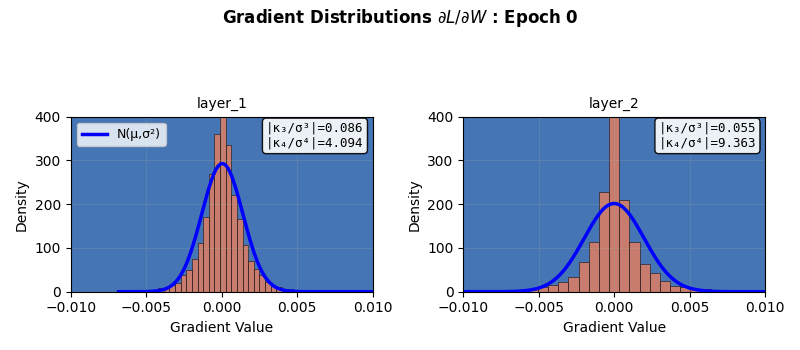

In [ ]:
from matplotlib.animation import FuncAnimation, PillowWriter

epochs_to_show = sorted(gradient_history.keys())
layers = sorted(gradient_history[epochs_to_show[0]].keys())

fig, axes = plt.subplots(1, len(layers), figsize=(4*len(layers), 3.5))

if len(layers) == 1:
    axes = [axes]

def update(frame_idx):
    epoch = epochs_to_show[frame_idx]
    
    for col, layer in enumerate(layers):
        ax = axes[col]
        ax.clear()
        
        grad_stats = gradient_history[epoch][layer]
        data = grad_stats['data']
        
        # Sample if needed
        if len(data) > 10000:
            data = np.random.choice(data, 10000, False)
        
        # Histogram
        ax.hist(data, bins=50, density=True, alpha=0.7,
               color='coral', edgecolor='black', linewidth=0.5)
        
        # Gaussian overlay
        mu, sigma = grad_stats['mean'], grad_stats['std']
        if sigma > 0:
            x = np.linspace(data.min(), data.max(), 200)
            ax.plot(x, norm.pdf(x, mu, sigma), 'b-', linewidth=2.5, label='N(μ,σ²)')
        
        # Color by Gaussianity
        score = grad_stats['score']
        colors = ['#d73027', '#fc8d59', '#fee090', '#91bfdb', '#4575b4']
        ax.set_facecolor(colors[min(4, int(score * 5))])
        
        # Stats
        txt = f"|K_3/sigma^3|={grad_stats['std_k3']:.3f}\n|K_4/sigma^4|={grad_stats['std_k4']:.3f}"
        ax.text(0.97, 0.97, txt, transform=ax.transAxes, va='top', ha='right',
               bbox=dict(boxstyle='round', fc='white', alpha=0.9),
               fontsize=9, family='monospace')
        
        # Title
        ax.set_title(f'{layer}', fontsize=10)
        ax.set_xlabel('Gradient Value', fontsize=10)
        ax.set_ylabel('Density', fontsize=10)
        ax.grid(True, alpha=0.2)
        ax.set_xlim([-0.01, 0.01])
        ax.set_ylim([0,400])
        if col == 0:
            ax.legend(fontsize=9)
    
    fig.suptitle(f'Gradient Distributions '+r'$\partial L/\partial W$'+f' : Epoch {epoch}\n',
                 fontsize=12, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.93])

# Create animation
print(f"Creating gradient distribution animation ({len(epochs_to_show)} frames)...")
anim = FuncAnimation(fig, update, frames=len(epochs_to_show), interval=100, repeat=True)

# Save GIF
anim.save('./clt-ml-outputs/gradient_distributions.gif', writer=PillowWriter(fps=8))
plt.close()

from IPython.display import Image, display
display(Image('./clt-ml-outputs/gradient_distributions.gif'))

## Q-Q Plots for Gradients

Creating gradient Q-Q plot animation (84 frames)...


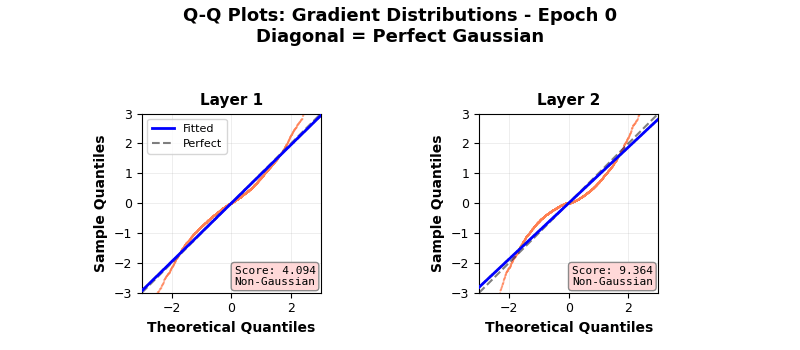

In [ ]:
from scipy.stats import probplot

# Create animated GIF of gradient Q-Q plots
epochs_to_show = sorted(gradient_history.keys())
layers = sorted(gradient_history[epochs_to_show[0]].keys())

fig, axes = plt.subplots(1, len(layers), figsize=(4*len(layers), 3.5))

if len(layers) == 1:
    axes = [axes]

def update_qq(frame_idx):
    epoch = epochs_to_show[frame_idx]
    
    for col, layer in enumerate(layers):
        ax = axes[col]
        ax.clear()
        
        grad_stats = gradient_history[epoch][layer]
        data = grad_stats['data']
        
        # Sample
        if len(data) > 5000:
            data = np.random.choice(data, 5000, False)
        
        # Standardize
        data_std = (data - data.mean()) / (data.std() + 1e-10)
        
        # Q-Q plot
        (osm, osr), (slope, intercept, r) = probplot(data_std, dist="norm", fit=True)
        
        ax.scatter(osm, osr, alpha=0.4, s=2, color='coral', edgecolors='none', rasterized=True)
        ax.plot(osm, slope * osm + intercept, 'b-', linewidth=2, label='Fitted', zorder=10)
        
        lims = [-3, 3]
        ax.plot(lims, lims, 'k--', linewidth=1.5, alpha=0.5, label='Perfect', zorder=5)
        
        ax.set_xlim(lims)
        ax.set_ylim(lims)
        ax.set_aspect('equal')
        
        # Score box
        score = grad_stats['score']
        box_color = '#d4f1d4' if score < 0.1 else ('#fff4d4' if score < 0.2 else '#ffd4d4')
        is_gauss = "✓ Gaussian" if score < 0.2 else "Non-Gaussian"
        
        ax.text(0.97, 0.03, f"Score: {score:.3f}\n{is_gauss}",
               transform=ax.transAxes, va='bottom', ha='right',
               bbox=dict(boxstyle='round', fc=box_color, ec='gray', alpha=0.9),
               fontsize=8, family='monospace')
        
        ax.set_title(f'{layer.replace("_", " ").title()}', fontweight='bold', fontsize=11)
        ax.grid(True, alpha=0.3, linewidth=0.5)
        ax.tick_params(labelsize=9)
        ax.set_xlabel('Theoretical Quantiles', fontsize=10, fontweight='bold')
        ax.set_ylabel('Sample Quantiles', fontsize=10, fontweight='bold')
        if col == 0:
            ax.legend(fontsize=8, loc='upper left')
    
    fig.suptitle(f'Q-Q Plots: Gradient Distributions - Epoch {epoch}\nDiagonal = Perfect Gaussian',
                 fontsize=13, fontweight='bold')
    
    plt.tight_layout(rect=[0, 0, 1, 0.93])

# Create animation
print(f"Creating gradient Q-Q plot animation ({len(epochs_to_show)} frames)...")
anim = FuncAnimation(fig, update_qq, frames=len(epochs_to_show), interval=100, repeat=True)

# Save GIF
anim.save('./clt-ml-outputs/gradient_qq_plots.gif', writer=PillowWriter(fps=8))
plt.close()

from IPython.display import Image, display
display(Image('./clt-ml-outputs/gradient_qq_plots.gif'))